In [1]:

import time
import numpy as np
from setup_pybullet import Simulation
from tools import getcubeplacement, setupwithmeshcat
import pinocchio as pin

from control_utils import *
from trajectory_optimizer import TrajectoryOptimizer
from trajectory_plots import trajectory_analysis
    
# in my solution these gains were good enough for all joints but you might want to tune this.
Kp = 6000.               # proportional gain (P of PD)
Kv = 2 * np.sqrt(Kp)   # derivative gain (D of PD)

def controllaw(sim: Simulation, robot, trajs, tcurrent):
    pos_traj, vel_traj, acc_traj = trajs

    qr, vqr, aqr = pos_traj(tcurrent), vel_traj(tcurrent), acc_traj(tcurrent)
    q, vq = sim.getpybulletstate()
    M = pin.crba(robot.model, robot.data, q)
    h = pin.nle(robot.model, robot.data, q, vq)

    # Update the robot's geometry placements based on the current configuration q
    pin.updateGeometryPlacements(robot.model, robot.data, robot.collision_model, robot.collision_data, q)
    pin.updateFramePlacements(robot.model, robot.data)

    left_end_effector_jacobian = pin.computeFrameJacobian(robot.model, robot.data, q, robot.model.getFrameId('LARM_EFF'))
    right_end_effector_jacobian = pin.computeFrameJacobian(robot.model, robot.data, q, robot.model.getFrameId('RARM_EFF'))
    
    gripping_force = 150

    left_force_6d = np.array([0, -1, 0, 0, 0, -0.03])
    right_force_6d = np.array([0, -1, 0, 0, 0, 0.03])

    # Probably we are having the wrong frame. The force vector should be in the end effector frame, not the world frame.
    gripping_tau = left_end_effector_jacobian.T @ left_force_6d * gripping_force + right_end_effector_jacobian.T @ right_force_6d * gripping_force

    aqd = aqr - Kp * (q - qr) - Kv * (vq - vqr)
    tau = M @ aqd + h + gripping_tau
    sim.step(tau)

pybullet build time: Oct 14 2023 16:04:51


In [2]:
from tools import setupwithpybulletandmeshcat, rununtil
from config import DT

robot, cube, viz = setupwithmeshcat()

from config import CUBE_PLACEMENT, CUBE_PLACEMENT_TARGET    
from inverse_geometry import computeqgrasppose
from path import computepathwithcubepos, displaypath

q0,successinit = computeqgrasppose(robot, robot.q0, cube, CUBE_PLACEMENT, None)

tcur = 0.
total_time = 3.

# Create a trajectory
# trajs = create_naive_bezier_trajectory(pose_waypoints, cube_waypoints, total_time=total_time, ramp_time=0.5, n_samples=1000)

trajs = create_optimized_bezier_trajectory()

# Sample the trajectory
bezier_samples = np.linspace(0, total_time, 1000)
q = []
for t in bezier_samples:
    q.append(trajs[0](t))
q = np.array(q)

Wrapper tries to connect to server <tcp://127.0.0.1:6000>
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [3]:
import numpy as np
from base_path_cost_evaluator import *
import pinocchio as pin
from config import LEFT_HAND, RIGHT_HAND
from inverse_geometry_utils import distanceToObstacle
from tools import setupwithmeshcat
import numpy as np

def to_cube_path(robot, q_trajectory):
    cube_path = []
    for q in q_trajectory:
        pin.framesForwardKinematics(robot.model, robot.data, q)
        # Compute left and right end effector frames
        left_end_effector_placement = robot.data.oMf[robot.model.getFrameId(LEFT_HAND)]
        right_end_effector_placement = robot.data.oMf[robot.model.getFrameId(RIGHT_HAND)]
        # Compute cube placement as the average of the left and right end effector translations
        cube_placement = (left_end_effector_placement.translation + right_end_effector_placement.translation) / 2
        cube_path.append(cube_placement)
    return np.array(cube_path)

def trajectory_analysis(q0, q_trajectory, dt): # dt is time between frames
    robot, cube, viz = setupwithmeshcat()
    # Calculate cube trajectory
    cube_trajectory = to_cube_path(robot, q_trajectory)
    # Calculate the distance the cube has traveled from frame to frame
    cube_distance = np.cumsum(np.linalg.norm(np.diff(cube_trajectory, axis=0), axis=1))
    # Calculate the per frame velocity of the cube
    cube_velocity = np.diff(cube_trajectory, axis=0) / dt
    # Calculate the per frame acceleration of the cube
    cube_acceleration = np.diff(cube_velocity, axis=0) / dt
    # Calculate the per frame velocity per joint
    joint_velocity = np.diff(q_trajectory, axis=0) / dt
    # Calculate the per frame acceleration per joint
    joint_acceleration = np.diff(joint_velocity, axis=0) / dt
    # Calculate distance to obstacle per frame
    obstacle_distances = []
    for q in q_trajectory:
        obstacle_distances.append(distanceToObstacle(robot, q))
    obstacle_distances = np.array(obstacle_distances)
    # Calculate the cube grasping residual per frame
    original = relative_transform(robot, q0)
    cube_grasping_residual = []
    for q in q_trajectory:
        current = relative_transform(robot, q)
        cube_grasping_residual.append(np.linalg.norm(current.homogeneous - original.homogeneous))
    cube_grasping_residual = np.array(cube_grasping_residual)
    # return cube_trajectory, cube_distance, cube_velocity, cube_acceleration, joint_velocity, joint_acceleration, obstacle_distances, cube_grasping_residual
    return {
        'cube_trajectory': cube_trajectory,
        'cube_distance': cube_distance,
        'cube_velocity': cube_velocity,
        'cube_acceleration': cube_acceleration,
        'joint_velocity': joint_velocity,
        'joint_acceleration': joint_acceleration,
        'obstacle_distances': obstacle_distances,
        'cube_grasping_residual': cube_grasping_residual
    }

def relative_transform(robot, q0):
    pin.framesForwardKinematics(robot.model, robot.data, q0)
    # Compute left and right end effector frames
    left_end_effector_placement = robot.data.oMf[robot.model.getFrameId(LEFT_HAND)]
    right_end_effector_placement = robot.data.oMf[robot.model.getFrameId(RIGHT_HAND)]
    relative_transform = left_end_effector_placement.inverse() * right_end_effector_placement
    return relative_transform

In [4]:
# Assume 4 seconds and 1000 samples, thus we have delta time
dt = 4 / 1000

a = trajectory_analysis(q0, q, dt)

Wrapper tries to connect to server <tcp://127.0.0.1:6000>
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [5]:
a[1].shape

(999,)

In [6]:
a[4][:, 0].shape

(999,)

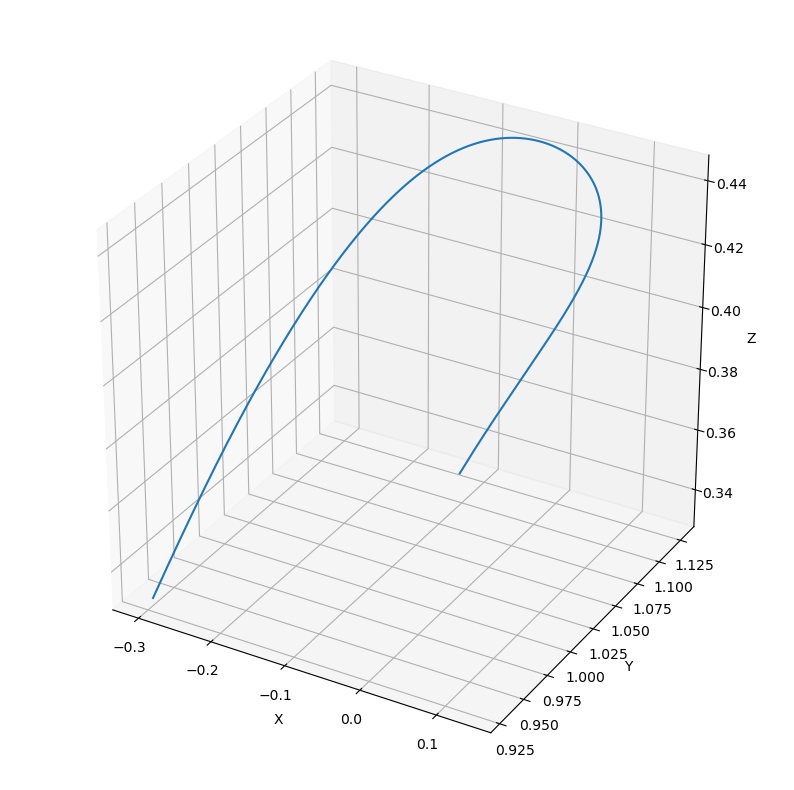

In [7]:
# Plot a[0] over time in 3D, aligned in YZ plane
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(a[0][:, 1], a[0][:, 2], a[0][:, 0])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

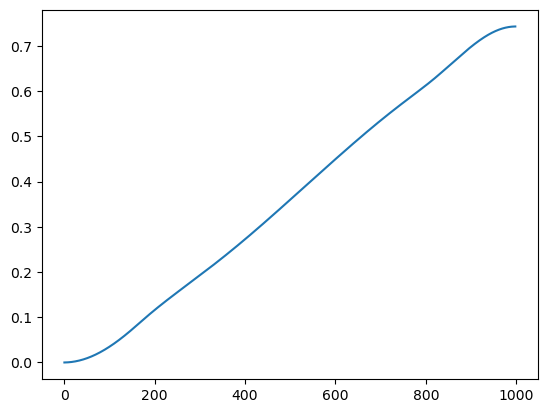

In [8]:
# Plot distance traveled over time
plt.plot(a[1])

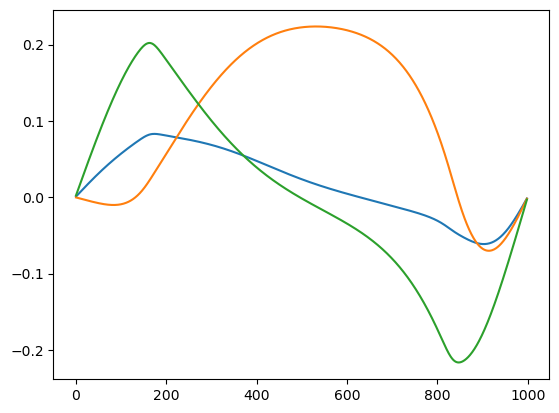

In [9]:
# Plot velocity over time
plt.plot(a[2])

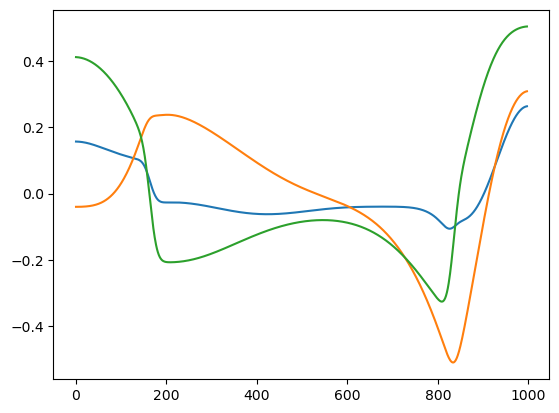

In [10]:
# Plot acceleration over time
plt.plot(a[3])

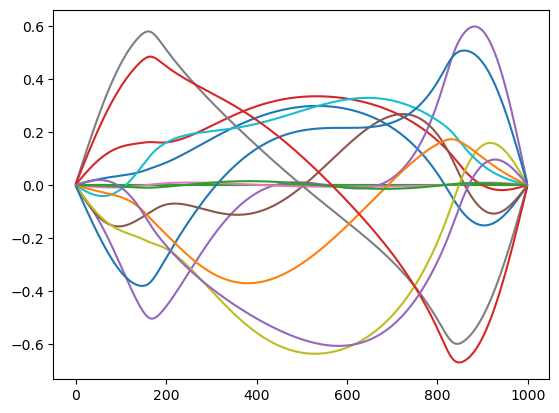

In [11]:
# Plot joint velocity over time
plt.plot(a[4])

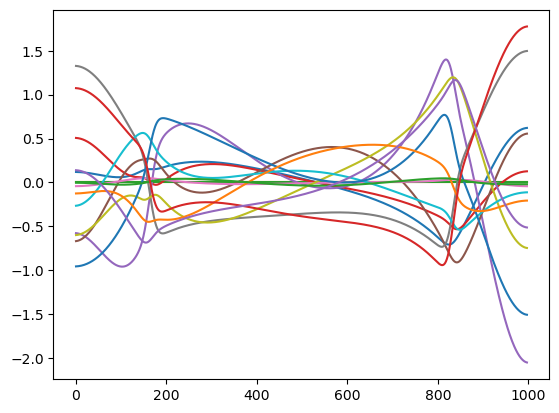

In [12]:
# Plot joint acceleration over time
plt.plot(a[5])

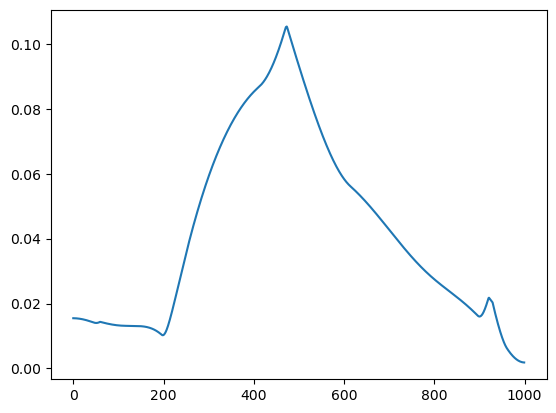

In [13]:
# Plot distance to obstacle over time
plt.plot(a[6])

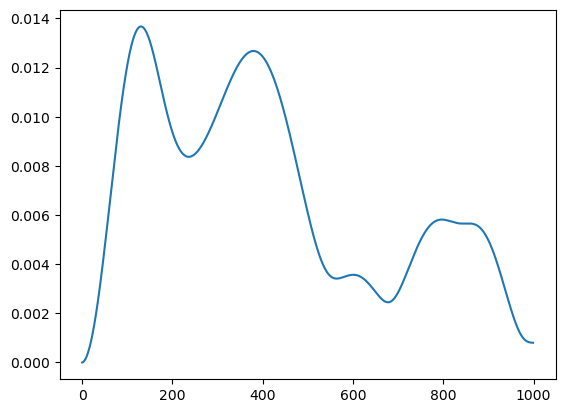

In [14]:
# Plot cube grasping residual over time
plt.plot(a[7])